<font color="#e32b3d"><h1>HW1 : Question 3: Auto-Encoders for Classification</h2></font>

<font color="#2ff9b3d"><h1>part A: Pre-processing </h1></font>

required library and packages are imported.

In [2221]:
# Import library
import pandas  as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 


Importing the MNIST dataset into train and test sets.

    *note that using torch.vision requiers to transform dataset into tensors using *ToTensor()*, this function normalizes all the features in dataset and no further normalization is needed.

In [2222]:
import torch
import torchvision
import torchvision.transforms as transforms
Train_set = torchvision.datasets.MNIST(root="./", download=True,train=True, transform=transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.MNIST(root="./", download=True,train=False, transform=transforms.Compose([transforms.ToTensor()]))

checking if the data is normalized.

In [2223]:
max = Train_set[0][0].max()
min = Train_set[0][0].min()
print("Dataset is normalized with maximum value of "+ str(max)+" and minimum value of "+str(min))

Dataset is normalized with maximum value of tensor(1.) and minimum value of tensor(0.)


In [2224]:
# We move our tensor to the GPU if available
if (torch.cuda.is_available()):
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'
print(DEVICE)

cpu


In [2225]:
train_images = Train_set.data
train_lables = Train_set.targets

test_images = test_set.data
test_lables = test_set.targets

making a list out of train labels:

In [2226]:
dff = pd.DataFrame(train_lables.numpy(), columns=["labels"])
classes = list(set(dff['labels'].values))
dist = []
#creating a list out of number of times each label is repeated.
for i in classes:
    dist.append((dff.labels == i).sum())    

Displaying the label of train data vs. classes:

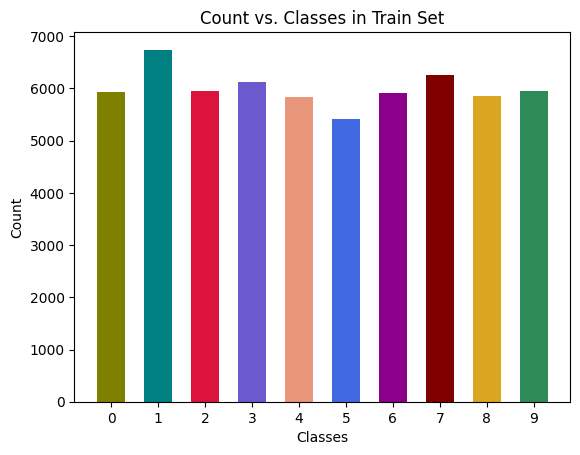

<Figure size 640x480 with 0 Axes>

In [2227]:
X = classes
Y = dist
plt.bar(X, Y, color=['olive', 'teal', 'crimson', 'slateblue', 'darksalmon', 'royalblue', 'darkmagenta', 'maroon', 'goldenrod','seagreen'],
        width = 0.6)

plt.xticks(X)
plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Count vs. Classes in Train Set")
plt.show()
plt.tight_layout()

Visualising 5 random images from train set:

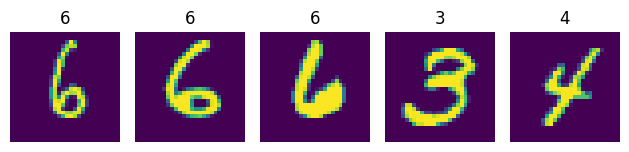

In [2228]:
from numpy.random import randint
import matplotlib.pyplot as plt

rand_ix = randint(0, len(Train_set), 5)
figure, axs = plt.subplots(1, 5) 
counter = 0
for j in range(5):
    im = Train_set[rand_ix[j]][0]
    label = Train_set[rand_ix[j]][1]
    imgTmp = torch.transpose(im,0,2)
    axs[j].set_title(str(label))
    axs[j].axis('off')
    axs[j].imshow(torch.transpose(imgTmp, 0, 1).reshape((28,28)), cmap="viridis")
    plt.tight_layout()


a simple class to convert dataframes into corresponding tensors:

In [2229]:
import torch
class MyDataset():
  def __init__(self, dataset):

    x = dataset.drop((dataset.shape[1]-1), axis = 1).values
    y = dataset[(dataset.shape[1]-1)].values
    # Change into tensors:
    self.x_train=torch.tensor(x,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.int64)

  def __len__(self):
    return len(self.y_train)
  
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

<font color="#2ff9b3d"><h1>part B: Auto-Encoder Network </h1></font>

Auto-Encoder class:

28 * 28 ==> 500 ==> 300 ==> 100 ==> 30 ==> 100 ==>300 ==> 500 ==> 28 * 28 

Returns both *encoded* and *decoded* results.

In [2230]:
# Creating a PyTorch class
# 28*28 ==> 30 ==> 28*28
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 30
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 300),
            torch.nn.ReLU(),
            torch.nn.Linear(300, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 30)
        )
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 30 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(30, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 300),
            torch.nn.ReLU(),
            torch.nn.Linear(300, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 28*28),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        self.encoded = self.encoder(x)
        decoded = self.decoder(self.encoded)
        return self.encoded, decoded

    *The method for fitting an epoch of data to the model

In [2231]:
def AE_fit(model, train_loader, optimizer,  criterion):
    train_running_loss = 0.0
    counter = 0
    model.train()   # Training mode (allow weight updates)
    model = model.to(DEVICE)
    # Validation using Loss function
    loss_function = criterion

    for (image, _) in train_loader:
      image = image.to(DEVICE)
      image = image.reshape(-1, 28*28)
      # Output of Autoencoder
      encoded, reconstructed = model(image)
      # Calculating the loss function
      loss = loss_function(reconstructed, image)
      train_running_loss += loss.item()
      # The gradients are set to zero,
      # the gradient is computed and stored.
      # .step() performs parameter update
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      counter += 1 
    train_loss = train_running_loss / counter ## Total epoch loss
    return model, train_loss, reconstructed, image

    *The method for evaluating the validation data

in this method the actual and predicted outputs are used for model evaluations.

In [2232]:
def AE_validation(model, data_loader, criterion):
    val_running_loss = 0.0
    counter = 0
    model.eval()    ## Evaluation mode (do not allow weight updates)
    # Validation using Loss function
    loss_function = criterion
    for (image, _) in data_loader:
        counter += 1
        # Reshaping the image to (-1, 784)
        image = image.to(DEVICE)
        image = image.reshape(-1, 28*28)
        # Output of Autoencoder
        encoded, reconstructed = model(image)
        # Calculating the loss function
        loss = loss_function(reconstructed, image)
        val_running_loss += loss.item()
        # ## No backprop here (because we are validating)
    val_loss = val_running_loss / counter
    return val_loss

    *The main method for training the model through epochs

in this method, first based on the hparam values the learning rate and number of epochs is set. the optimizer is set to *SGD* and the for loss function the *MSE* is used.

then for each epoch, *fit* and *validation* functions are called.

at the end of the training the trained model, train.validation losses and the anctual and reconstructed batch of images is returned.


In [2233]:
import torch.optim as optim
import time

def AE_train(hparams, train_loader, val_loader):
    train_loss = []
    val_loss = []
    #model initialization
    model = AE()
    ## Loss Function
    criterion = torch.nn.MSELoss()
    ## Optimizer
    optimizer = optim.SGD(model.parameters(), lr=hparams["lr"], momentum=0.9)

    start = time.time()
    ## Loop over epochs
    for epoch in range(hparams['epochs']):
        print(f"Epoch {epoch+1} of {hparams['epochs']}")
        ## Fit the model using the training set
        model, train_epoch_loss, reconstruct ,actual_image= AE_fit(model, train_loader,optimizer, criterion)
        ## Evaluate the model on the val set
        val_epoch_loss = AE_validation(model, val_loader, criterion)   

        train_loss.append(train_epoch_loss)
        val_loss.append(val_epoch_loss)
        print(f"Train Loss: {train_epoch_loss:.4f},\
         Val Loss: {val_epoch_loss:.4f},")

    end = time.time()
    print(f"Training time: {(end-start)/60:.3f} minutes")
    return model, train_loss, val_loss, reconstruct, actual_image

Splitting the train set into train and validation and the creating a dataloader to feed them to the network.

In [2234]:
from torch.utils.data import random_split, DataLoader

AE_batch_size=100
## Train-val split
train_set, val_set = random_split(Train_set, [50000, 10000])

print(f"Size of the training set: {len(train_set)}")
print(f"Size of the validation set: {len(val_set)}")
print(f"Size of the test set: {len(test_set)}")

## Create the data loaders
train_loader = DataLoader(train_set, batch_size=AE_batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=AE_batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=AE_batch_size, shuffle=True)

Size of the training set: 50000
Size of the validation set: 10000
Size of the test set: 10000


In [2235]:
## Training the Auto-Encoder
hparams = {'batch_size': AE_batch_size, 'lr': 0.5, 'epochs': 20}
trained_AE, train_loss, val_loss, reconstructed_image, actual= AE_train(hparams, train_loader, val_loader)

Epoch 1 of 20
Train Loss: 0.0822,         Val Loss: 0.0634,
Epoch 2 of 20
Train Loss: 0.0618,         Val Loss: 0.0602,
Epoch 3 of 20
Train Loss: 0.0573,         Val Loss: 0.0542,
Epoch 4 of 20
Train Loss: 0.0523,         Val Loss: 0.0499,
Epoch 5 of 20
Train Loss: 0.0472,         Val Loss: 0.0443,
Epoch 6 of 20
Train Loss: 0.0422,         Val Loss: 0.0390,
Epoch 7 of 20
Train Loss: 0.0364,         Val Loss: 0.0338,
Epoch 8 of 20
Train Loss: 0.0324,         Val Loss: 0.0305,
Epoch 9 of 20
Train Loss: 0.0295,         Val Loss: 0.0282,
Epoch 10 of 20
Train Loss: 0.0277,         Val Loss: 0.0267,
Epoch 11 of 20
Train Loss: 0.0265,         Val Loss: 0.0257,
Epoch 12 of 20
Train Loss: 0.0256,         Val Loss: 0.0250,
Epoch 13 of 20
Train Loss: 0.0248,         Val Loss: 0.0242,
Epoch 14 of 20
Train Loss: 0.0241,         Val Loss: 0.0238,
Epoch 15 of 20
Train Loss: 0.0234,         Val Loss: 0.0230,
Epoch 16 of 20
Train Loss: 0.0227,         Val Loss: 0.0221,
Epoch 17 of 20
Train Loss: 0.0219

In [2236]:
#Saving the trained AE
torch.save(trained_AE.state_dict(), 'trained_AE')

To check the functionality of the autoencoder, the last actual and reconstructed image are visualised.

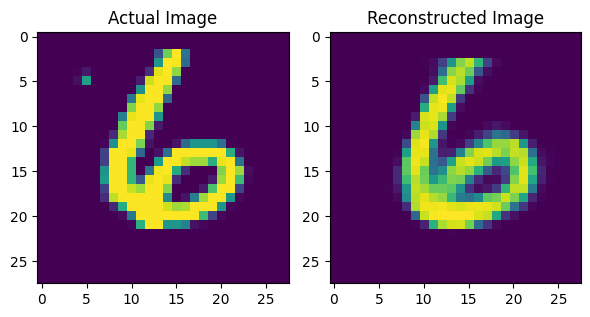

In [2237]:
## Visualising a sample of actual and reconstructed images
plt.figure(figsize=(6,6))
plt.subplot(2, 2, 1)
item = (actual[AE_batch_size-2].reshape(-1, 28*28))
item = item.reshape(-1, 28, 28)
plt.imshow(item[0].cpu().detach().numpy())
plt.title("Actual Image")
plt.autoscale()

plt.subplot(2, 2, 2)
item = reconstructed_image[AE_batch_size-2].reshape(-1, 28*28)
item = item.reshape(-1, 28, 28)
plt.imshow(item[0].cpu().detach().numpy())
plt.title("Reconstructed Image")
plt.autoscale()

plt.tight_layout()


    *training and validation loss vs. epoch for auto-encoder.

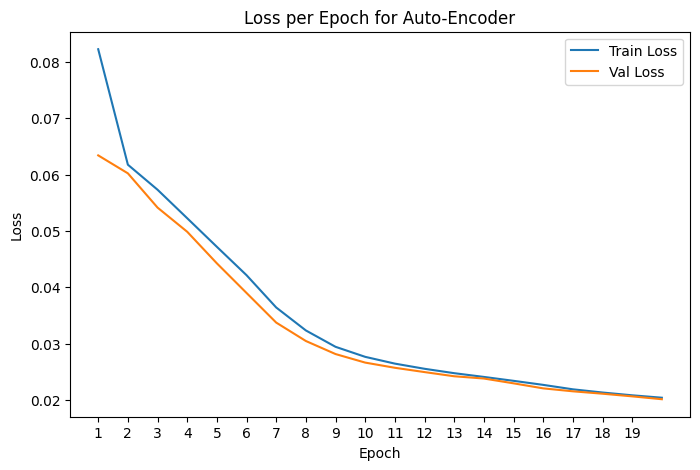

In [2238]:
## Plotting the training loss and validation loss vs epochs
plt.figure(figsize=(8, 5))
plt.plot(list(range(1,len(train_loss)+1)), train_loss, label='Train Loss')
plt.plot(list(range(1,len(val_loss)+1)), val_loss, label='Val Loss')
plt.title('Loss per Epoch for Auto-Encoder')
tick_marks = np.arange(len(range(hparams['epochs'])))
plt.xticks(tick_marks, range(hparams['epochs']))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.autoscale()
plt.legend()

<font color="#2ff9b3d"><h1>part C: Classification  </h1></font>

the *preprocessing* function uses the encoded part of the trained auto-encoder and reshapes all the MNIST dataset into having 30 features. this function returns a dataframe.

In [2239]:
def Preprocessing(model, data_loader):
    counter = 0
    columns = [i for i in range(31)]
    batch_size = train_loader.batch_size
    label_column = []
  
    df = pd.DataFrame(columns=columns)
    model.eval()    ## Evaluation mode (do not allow weight updates)
    model.load_state_dict(torch.load('trained_AE'))
    for (image, labels) in data_loader:
        image = image.to(DEVICE)
        image = image.reshape(-1, 28*28)
        # Output of Autoencoder
        encoded, reconstructed = model(image)
        temp_df = pd.DataFrame(data=np.concatenate((encoded.detach().numpy(), (labels.detach().numpy().reshape(batch_size, 1))), axis = 1), columns=columns)
        df = pd.concat([df, temp_df])
        counter += 1
    return df

Dimension Reduction for train, validation and test sets.

In [2240]:
DR_train_df = Preprocessing(trained_AE, train_loader)
DR_val_df = Preprocessing(trained_AE, val_loader)
DR_test_df = Preprocessing(trained_AE, test_loader)

In [2256]:
DR_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,3.959987,-7.541953,1.127539,3.050413,-6.889112,-1.059252,-3.567142,0.858062,-10.036297,-4.179616,...,6.531278,9.058754,6.344368,3.185543,-1.825446,-1.318675,-0.622472,6.570090,3.479529,9.0
1,1.324899,-5.651095,-0.834956,2.536562,-9.906751,0.129007,-1.921279,2.321182,-7.443639,-2.965323,...,8.171686,12.344302,6.016605,4.625306,-6.735673,-0.127585,4.298642,7.078179,-0.285485,7.0
2,-3.661413,-5.726863,-13.168493,-3.224572,-9.241544,0.872386,-4.435365,1.192447,-5.083215,-2.852368,...,3.743181,13.395475,7.409472,9.349843,-2.923809,2.860958,1.252937,1.148046,-0.929400,0.0
3,7.805335,-6.452654,3.689734,3.539483,-3.313233,3.408487,-5.182032,1.848785,-10.299103,0.427547,...,0.298267,-0.011019,3.246523,6.904319,-4.219474,0.268438,2.424850,10.880562,1.564363,1.0
4,0.567145,-4.068595,-5.288756,0.278229,-6.408182,-1.473763,-7.566933,2.716445,-5.307080,-1.510949,...,2.762788,6.249556,1.974507,5.629575,-0.807243,1.190946,3.200981,5.331183,2.270095,4.0


A simple fully connected network with 2 hidden layers for multi class classification.

In [2242]:
import torch.nn as nn
import torch.nn.functional as F

# Fully-connected neural network
class FC(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FC, self).__init__()
        
        ## Input layer, 2 hidden layers and softmax layer
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size)  
        self.fc3 = nn.Linear(hidden_size, num_classes)  
        self.softm = nn.Softmax(dim=1)

    def forward(self, x):
        # The forward pass
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = self.softm(out)
        return out


    *The method for fitting an epoch of data to the model

In [2243]:
def FC_fit(model, train_loader, optimizer, criterion):
    model.train()   # Training mode (allow weight updates)
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    for i, data in enumerate(train_loader):
        counter += 1
        data, target = data[0].to(DEVICE), data[1].to(DEVICE)
        data = data.reshape(-1, 30)    ## Reshape the image data for the fully-connected NN
        total += target.size(0)
        optimizer.zero_grad()   # Reset gradients
        outputs = model(data)   # Calculate outputs
        loss = criterion(outputs, target)     ## Calculate Loss
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item() ## Number of correct preds
        loss.backward()   ## Backpropage the loss and calculate the gradients
        optimizer.step()   ## Update the weights using backpropagation
        
    train_loss = train_running_loss / counter ## Total epoch loss
    train_accuracy = 100. * train_running_correct / total ## Mean epoch accuracy
    return train_loss, train_accuracy

    *The method for evaluating the validation data

In [2244]:
## The method for evaluating the validation data

def FC_validation(model, data_loader, criterion):
    model.eval()    ## Evaluation mode (do not allow weight updates)
    val_running_loss = 0.0
    val_running_correct = 0
    counter = 0
    total = 0
    for i, data in enumerate(data_loader):
        counter += 1
        data, target = data[0].to(DEVICE), data[1].to(DEVICE)
        data = data.reshape(-1, 30)
        total += target.size(0)
        outputs = model(data)
        loss = criterion(outputs, target)
        val_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        val_running_correct += (preds == target).sum().item()
        ## No backprop here (because we are validating)
        
    val_loss = val_running_loss / counter
    val_accuracy = 100. * val_running_correct / total
    return val_loss, val_accuracy

    *The main method for training the model through epochs

in this method, first based on the hparam values the learning rate, number of hidden layer neurons and number of epochs are decided. then for each epoch, *fit* and *validation* functions are called.

In [2245]:
import torch.optim as optim
import time

## The main method for training the model through epochs
def FC_train(hparams, train_loader, val_loader):

    model = FC(30, hparams["hidden_layer_neurons"], 10)
    model.to(DEVICE) ## Model from CPU to GPU
    ## Optimizer: Adadelta
    optimizer = optim.Adadelta(model.parameters(), lr=hparams["lr"])
    ## Loss function: Cross Entropy
    criterion = nn.CrossEntropyLoss()
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []

    start = time.time()
    ## Loop over epochs
    for epoch in range(hparams['epochs']):
        print(f"Epoch {epoch+1} of {hparams['epochs']}")
        ## Fit the model using the training set
        train_epoch_loss, train_epoch_accuracy = FC_fit(model, train_loader, optimizer, criterion)
        ## Evaluate the model on the val set
        val_epoch_loss, val_epoch_accuracy = FC_validation(model, val_loader, criterion)  
        # Storing the losses
        train_loss.append(train_epoch_loss)
        train_accuracy.append(train_epoch_accuracy)

        val_loss.append(val_epoch_loss)
        val_accuracy.append(val_epoch_accuracy)
        
        print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f},\
         Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}")

    end = time.time()

    print(f"Training time: {(end-start)/60:.3f} minutes")
    return model, train_loss, train_accuracy, val_loss, val_accuracy

In [2246]:
# Hyperparameters dict
FC_batch_size = 50
hparams = {'batch_size': FC_batch_size, 'lr': 0.09, 'epochs': 50, 'hidden_layer_neurons':50}

changing dataframes into tensors and then creating dataloaders.

In [2247]:
train_dataset = MyDataset(DR_train_df)
val_dataset = MyDataset(DR_val_df)
test_dataset = MyDataset(DR_test_df)

# ## Create the data loaders
DR_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=FC_batch_size, shuffle=True)
DR_val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=FC_batch_size, shuffle=True)
DR_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=FC_batch_size, shuffle=True)

Training the Fully Connected model.

In [2248]:
trained_FC, FC_train_loss, FC_train_accuracy, FC_val_loss, FC_val_accuracy = FC_train(hparams, DR_train_loader, DR_val_loader) ### train the model

Epoch 1 of 50
Train Loss: 1.7996, Train Acc: 73.37,         Val Loss: 1.6268, Val Acc: 87.53
Epoch 2 of 50
Train Loss: 1.5998, Train Acc: 88.99,         Val Loss: 1.5884, Val Acc: 89.29
Epoch 3 of 50
Train Loss: 1.5778, Train Acc: 89.99,         Val Loss: 1.5758, Val Acc: 90.05
Epoch 4 of 50
Train Loss: 1.5675, Train Acc: 90.53,         Val Loss: 1.5676, Val Acc: 90.38
Epoch 5 of 50
Train Loss: 1.5610, Train Acc: 91.02,         Val Loss: 1.5627, Val Acc: 90.64
Epoch 6 of 50
Train Loss: 1.5565, Train Acc: 91.34,         Val Loss: 1.5590, Val Acc: 91.11
Epoch 7 of 50
Train Loss: 1.5535, Train Acc: 91.50,         Val Loss: 1.5564, Val Acc: 91.14
Epoch 8 of 50
Train Loss: 1.5508, Train Acc: 91.71,         Val Loss: 1.5548, Val Acc: 91.12
Epoch 9 of 50
Train Loss: 1.5489, Train Acc: 91.81,         Val Loss: 1.5526, Val Acc: 91.28
Epoch 10 of 50
Train Loss: 1.5472, Train Acc: 91.98,         Val Loss: 1.5520, Val Acc: 91.39
Epoch 11 of 50
Train Loss: 1.5455, Train Acc: 92.04,         Val Loss

In [2249]:
#Saving the trained AE
torch.save(trained_FC.state_dict(), 'trained_FC')

    *training and validation loss vs. epoch for Fully-Connected network.

******************************* Training Phase: Loss Evaluation *******************************


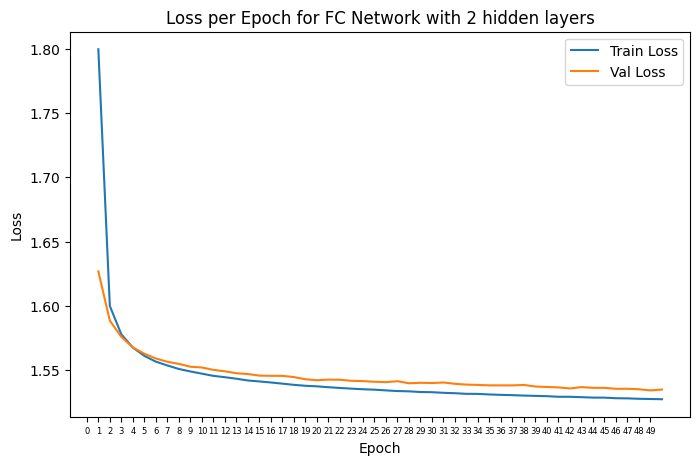

In [2250]:
print("******************************* Training Phase: Loss Evaluation *******************************")
## Plotting the training loss and validation loss vs epochs for each model
plt.figure(figsize=(8, 5))
plt.plot(list(range(1,len(FC_train_loss)+1)), FC_train_loss, label='Train Loss')
plt.plot(list(range(1,len(FC_val_loss)+1)), FC_val_loss, label='Val Loss')
plt.title('Loss per Epoch for FC Network with 2 hidden layers')
tick_marks = np.arange(len(range(hparams['epochs'])))
plt.xticks(tick_marks, range(hparams['epochs']) , fontsize= 6)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

    *training and validation accuracy vs. epoch for Fully-Connected network.

******************************* Training Phase: Accuracy Evaluation *******************************


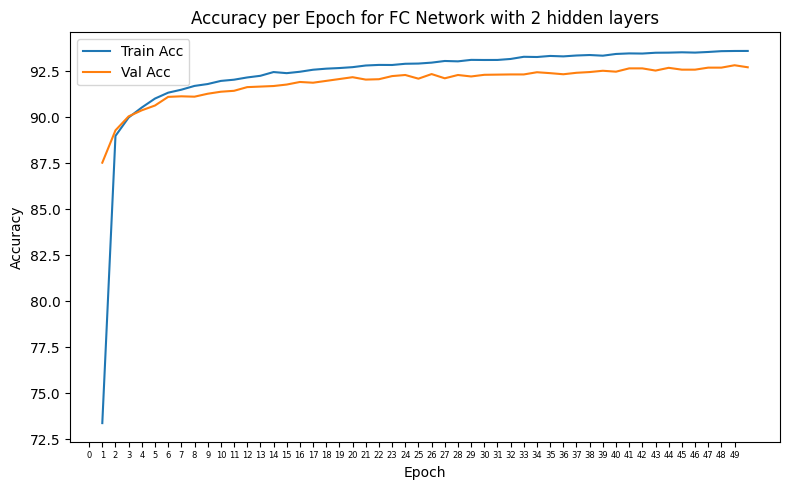

In [2251]:
print("******************************* Training Phase: Accuracy Evaluation *******************************")
## Plotting the training loss and validation loss vs epochs for each model
plt.figure(figsize=(8, 5))
plt.plot(list(range(1,len(FC_train_accuracy)+1)), FC_train_accuracy, label='Train Acc')
plt.plot(list(range(1,len(FC_val_accuracy)+1)), FC_val_accuracy, label='Val Acc')
plt.title('Accuracy per Epoch for FC Network with 2 hidden layers')
tick_marks = np.arange(len(range(hparams['epochs'])))
plt.xticks(tick_marks, range(hparams['epochs']) , fontsize= 6)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.legend()

    *The method for Testing the unseen data

in order to test the unseen data, the trained FC model is used.

Note that no gradient is required in test phase.


In [2252]:
def Testing (model,test_loader):
    model.eval()  # No training in post-processing
    test_running_loss = 0.0
    test_running_correct = 0
    counter = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    ## Using the trained_FC
    model.load_state_dict(torch.load('trained_FC'))

    with torch.no_grad():
        for i, data in enumerate(test_loader):
            counter += 1
            data, target = data
            data, target = data, target
            data = data.reshape(-1, 30)    ## Reshape the image data for the fully-connected NN
            total += target.size(0)
            outputs = model(data)
            loss = criterion(outputs, target)

            test_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            ## Storing the labels and predicted ones
            if counter==1 :
                y_true = (target.detach().numpy())
                y_pred = (target.detach().numpy())
            else:
                y_true = np.concatenate((y_true, np.array(target.detach().numpy())), axis=0)
                y_pred = np.concatenate((y_pred, np.array(preds.detach().numpy())), axis=0)
            test_running_correct += (preds == target).sum().item()

        test_loss = test_running_loss / counter
        test_accuracy = 100. * test_running_correct / total
    return test_loss, test_accuracy, y_true, y_pred

Testing the model with unseen data:

In [2253]:
test_loss, test_acc, test_true, test_pred = Testing(trained_FC, DR_test_loader)
print("Test Loss: "+ str(test_loss))
print("Test Accuracy: "+ str(test_acc))

Test Loss: 1.5349774754047394
Test Accuracy: 92.73


    Plotting the Confusion matrix:

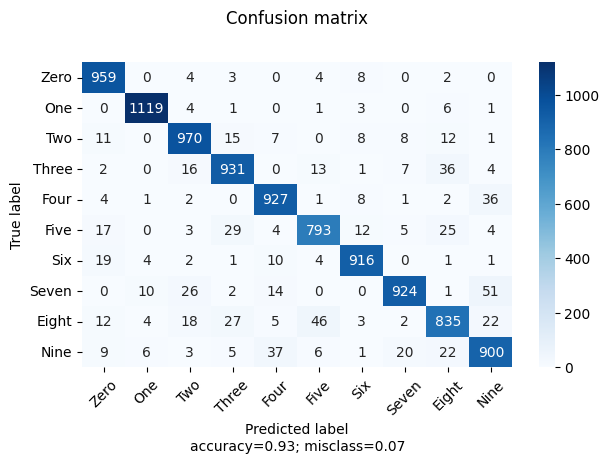

In [2254]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
cnf_matrix = confusion_matrix(test_true, test_pred)   ## Sklearn confusion matrix object
accuracy = np.trace(cnf_matrix) / float(np.sum(cnf_matrix))
misclass = 1 - accuracy
class_names = ["Zero","One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine"]

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap = "Blues" ,fmt='g', xticklabels=class_names , yticklabels=class_names)
ax.xaxis.set_label_position("bottom")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
plt.tight_layout()

    Classification Report:

In [2255]:
print(classification_report(test_true, test_pred, target_names=class_names))

              precision    recall  f1-score   support

        Zero       0.93      0.98      0.95       980
         One       0.98      0.99      0.98      1135
         Two       0.93      0.94      0.93      1032
       Three       0.92      0.92      0.92      1010
        Four       0.92      0.94      0.93       982
        Five       0.91      0.89      0.90       892
         Six       0.95      0.96      0.96       958
       Seven       0.96      0.90      0.93      1028
       Eight       0.89      0.86      0.87       974
        Nine       0.88      0.89      0.89      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

